导入所需的依赖

In [134]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time


数据读取类

In [266]:
class CloudDataset(Dataset):
    """云检测数据

    """
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True, is_train=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        self.is_train = is_train
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}
        return files
                                       
    def __len__(self):        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def open_false_color(self, idx):
        """读取假彩色图像"""
        path = self.files[idx]['red']
        file_name = "LC08" + path.name.split("LC08")[-1]
        path_splits = path.name.split("_by_")
        width = int(path_splits[0].split("_")[-1])
        heigh = int(path_splits[-1].split("_")[0])
        print(path, width, heigh)
        false_color_path = os.path.join(path.parent.parent, "Natural_False_Color", file_name)
        false_color_array = np.array(Image.open(false_color_path))
        size = 384
        
        false_color_array = false_color_array[int((width-1)*size):int((width)*size), int((heigh-1)*size):int((heigh)*size)]

        gt_path = os.path.join(path.parent.parent, "Entire_scene_gts", "edited_corrected_gts_" + file_name)
        gt_array = np.array(Image.open(gt_path))
        gt_array = gt_array[int((width-1)*size):int((width)*size), int((heigh-1)*size):int((heigh)*size)]
        return false_color_array, gt_array

    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        if self.is_train:
            y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)        
            return x, y
        else:
            false_color, gt_array = self.open_false_color(idx)
            return x, false_color, gt_array
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s
    


模型定义

In [267]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

一些工具类

In [351]:
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

def batch_to_img(xb, idx):
    img = np.array(xb[idx,1:4])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

训练模型

In [ ]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    


开始训练

In [ ]:
base_path = Path(r'D:\Data\MLData\MLData\segment\38cloud\38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))

train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)
unet = UNET(4,2)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)

# testing one pass
xb, yb = next(iter(train_dl))

train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=50)

In [301]:
base_path = Path(r'D:\Data\MLData\MLData\segment\95cloud\95-cloud_training_only_additional_to38-cloud')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt', pytorch=True)

test_dl = DataLoader(data, batch_size=1, shuffle=True)

unet = UNET(4,2)
unet.load_state_dict(torch.load(r"D:\Data\MLData\weights_unet_30.pth", map_location=torch.device('cpu')))        # 加载训练数据权重

unet1 = UNET(4,2)
unet1.load_state_dict(torch.load(r"D:\Data\MLData\weights_unet_28.pth", map_location=torch.device('cpu')))        # 加载训练数据权重


<All keys matched successfully>

Test complete in 0m 1s


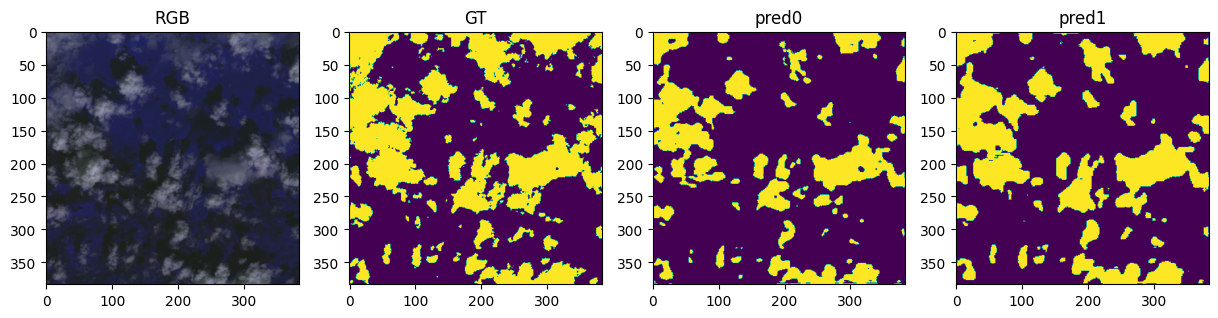

In [384]:

def test(model, model1, test_dl):
    start = time.time()
    model1.train(False)
    model.train(False)  # Set model to evaluate mode
    x, gt_array = next(iter(test_dl))
      
    with torch.no_grad():
        outputs = model(x)
        outputs1 = model1(x)
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(batch_to_img(x, 0))
    ax[0].set_title('RGB')
    ax[1].imshow(gt_array[0])
    ax[1].set_title('GT')
    ax[2].imshow(predb_to_mask(outputs, 0))
    ax[2].set_title('pred0')
    ax[3].imshow(predb_to_mask(outputs1, 0))
    ax[3].set_title('pred1')

    time_elapsed = time.time() - start
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

test(unet, unet1, test_dl)

Text(0.5, 1.0, 'RGB')

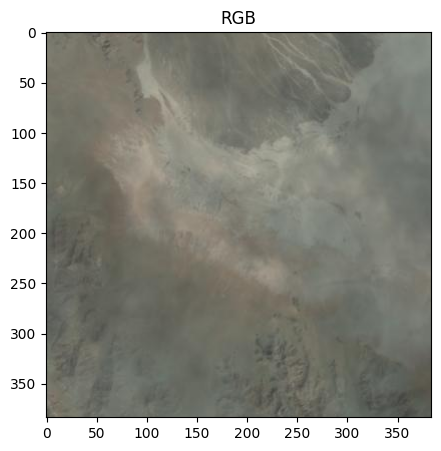

In [300]:
fc_path = r"D:\Data\MLData\MLData\segment\38cloud\38-Cloud_test\Natural_False_Color\LC08_L1TP_039035_20160320_20170224_01_T1.TIF"
fc_array = np.array(Image.open(fc_path))
size = 384
width = 2
heigh = 7
gt_array = fc_array[int((width-1)*size-85):int((width)*size-85), int((heigh-1)*size - 160):int((heigh)*size - 160)]
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(gt_array)
ax.set_title('RGB')